In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

# 데이터 경로
path = '/content/drive/MyDrive/모듈프젝2/A팀-회귀/data/playground-series-season-3-episode-6/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [ ]:
train.shape, test.shape, submission.shape

((22730, 18), (15154, 17), (15154, 2))

In [ ]:
# train, test 간 피처수가 맞지 않는다 -> 컬럼수 확인
print(train.columns)
print(test.columns)
print(submission.columns)

Index(['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')
Index(['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')
Index(['id', 'price'], dtype='object')


In [ ]:
'''
'id', : 고유 ID 
'squareMeters', : 방 면적
'numberOfRooms', : 방 개수
'hasYard', : 마당 존재 여부  ( binary )
'hasPool', : 수영장 존재 여부 ( binary )
'floors', : 
'cityCode', 
'cityPartRange', 
'numPrevOwners', 
'made', 
'isNewBuilt',
'hasStormProtector', 
'basement', 
'attic', 
'garage', 
'hasStorageRoom',
'hasGuestRoom', 
'price'
'''

train.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


# 데이터 준비 + EDA (분석, 피처엔지니어링 대상및 처리내용 체크)

In [ ]:
def summary_feature_info( df, train = train ):
    '''
      # 피처 요약 정보 생성하는 함수 구성 -> 피처를 빠르게 파악할수 있다
      # 전체 데이터 : 볼륨(형상) -> print()
      # 피처별 : 피처명, 타입,  결측치수, 고유값수, 샘플값0~2(0,1,2개정도) => DF로 구성 출력
      # 피처를 파악해 보겠다
    '''
    sum_df = pd.DataFrame( train.dtypes, columns=['type'])   
    # 인덱스 -> 컬럼으로 이동
    sum_df = sum_df.reset_index()
    # 컬럼명 index -> feature_name 변경
    sum_df.rename( columns={ 'index':'feature_name' }, inplace=True)

    # 결측치수
    sum_df['결측치수'] = train.isnull().sum().values

    # 고유값수
    sum_df['고유값수'] = train.nunique().values

    # 샘플값0~2(0,1,2개정도)
    sum_df['샘플값0'] = train.loc[0].values
    sum_df['샘플값1'] = train.loc[1].values
    sum_df['샘플값2'] = train.loc[2].values

    return sum_df

summary_df = summary_feature_info( train )
summary_df

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,id,int64,0,22730,0.0,1.0,2.0
1,squareMeters,int64,0,7319,34291.0,95145.0,92661.0
2,numberOfRooms,int64,0,100,24.0,60.0,45.0
3,hasYard,int64,0,2,1.0,0.0,1.0
4,hasPool,int64,0,2,0.0,1.0,1.0
5,floors,int64,0,101,47.0,60.0,62.0
6,cityCode,int64,0,7810,35693.0,34773.0,45457.0
7,cityPartRange,int64,0,10,2.0,1.0,4.0
8,numPrevOwners,int64,0,10,1.0,4.0,8.0
9,made,int64,0,33,2000.0,2000.0,2020.0


# EDA 분석

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

## Target 분포 확인

In [ ]:
fig = px.histogram(train,  x="price",
                   marginal="box", 
                   hover_data=train.columns,
                   color_discrete_sequence=['#0077b6']
                  )
fig.show()

# 1000만까지 균일하게 분포되어 있고, 1000만 이상은 거의 없다

## 연속형 데이터 시각화
- 연속형 데이터
- squareMeters, basement, attic, garage


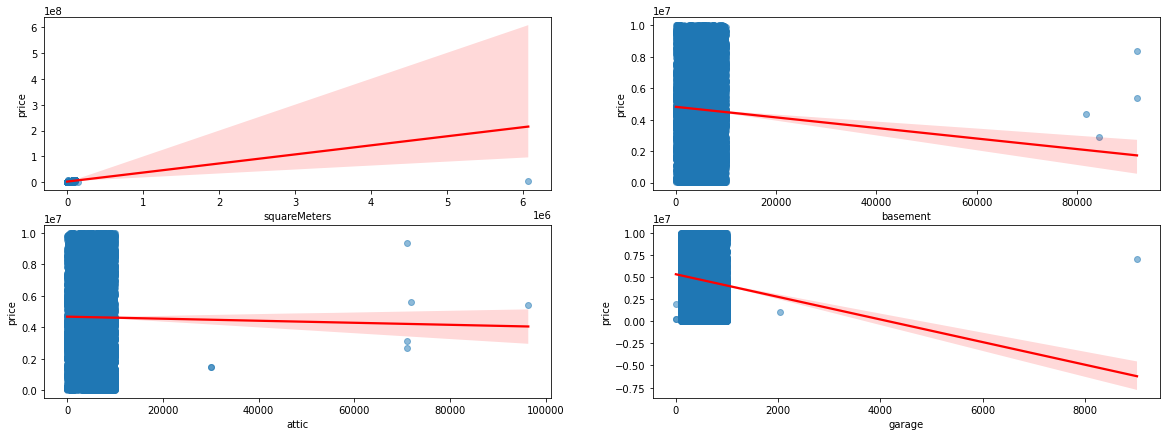

In [ ]:
# 2줄, 2칸 행렬형태로 차트 준비
fig, axes = plt.subplots(nrows=2, ncols=2)
# plt.tight_layout() 
fig.set_size_inches(20,7)

sns.regplot(x='squareMeters', y='price', data=train, ax=axes[0,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5})
sns.regplot(x='basement', y='price', data=train, ax=axes[0,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5})
sns.regplot(x='attic', y='price', data=train, ax=axes[1,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5})
sns.regplot(x='garage', y='price', data=train, ax=axes[1,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5})
'''
해석
- squareMeters : 면적이 높을수록 가격이 높아진다(양의 상관관계) - 사용
- basement, attic, garage은 모두 음의 상관관계 - 미사용
'''
plt.show()

## 수치형 데이터 시각화
  - 수치형 데이터
    - numberOfRooms, floors, cityPartRange, numPrevOwners

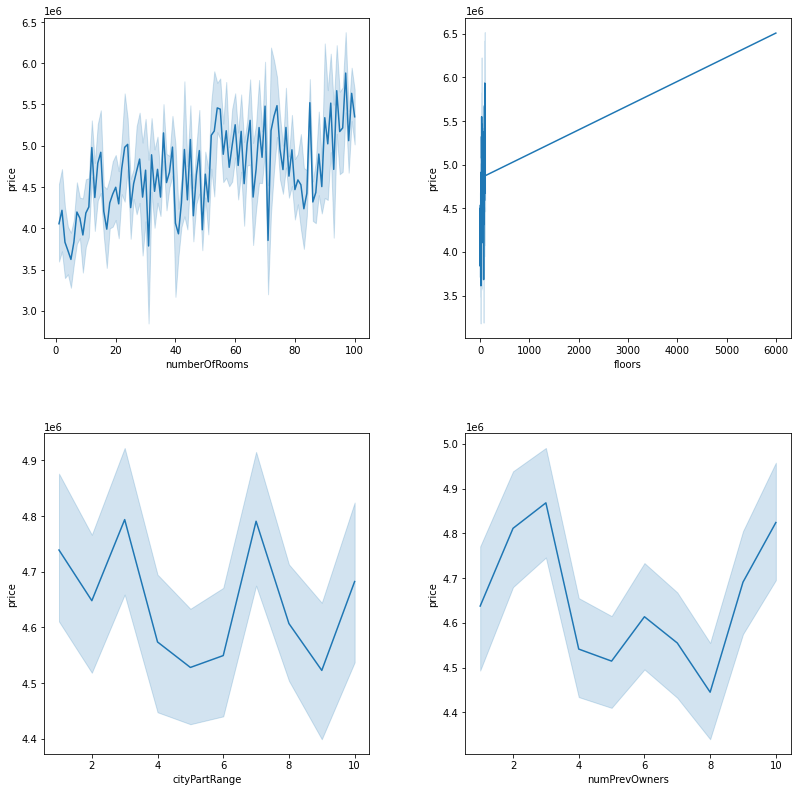

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout() 
fig.set_size_inches(12,12)

sns.lineplot(x='numberOfRooms', y='price', data=train, ax=axes[0,0])
sns.lineplot(x='floors', y='price', data=train, ax=axes[0,1])
sns.lineplot(x='cityPartRange', y='price', data=train, ax=axes[1,0])
sns.lineplot(x='numPrevOwners', y='price', data=train, ax=axes[1,1])


In [ ]:
train.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


## 범주형 데이터 시각화
  - 이진형 데이터
    - hasYard, hasPool, isNewBuilt, hasStormProtector, hasStorageRoom
  - 범주형 데이터
    - made

In [ ]:
bin_train = train[[ 'hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom']]
bin_train

,hasYard,hasPool,isNewBuilt,hasStormProtector,hasStorageRoom
0,1,0,0,1,0
1,0,1,0,1,0
2,1,1,1,1,1
3,0,0,0,1,1
4,0,0,1,0,0
...,...,...,...,...,...
22725,1,0,0,0,0
22726,1,0,0,1,0
22727,1,0,1,0,0
22728,1,0,1,0,0


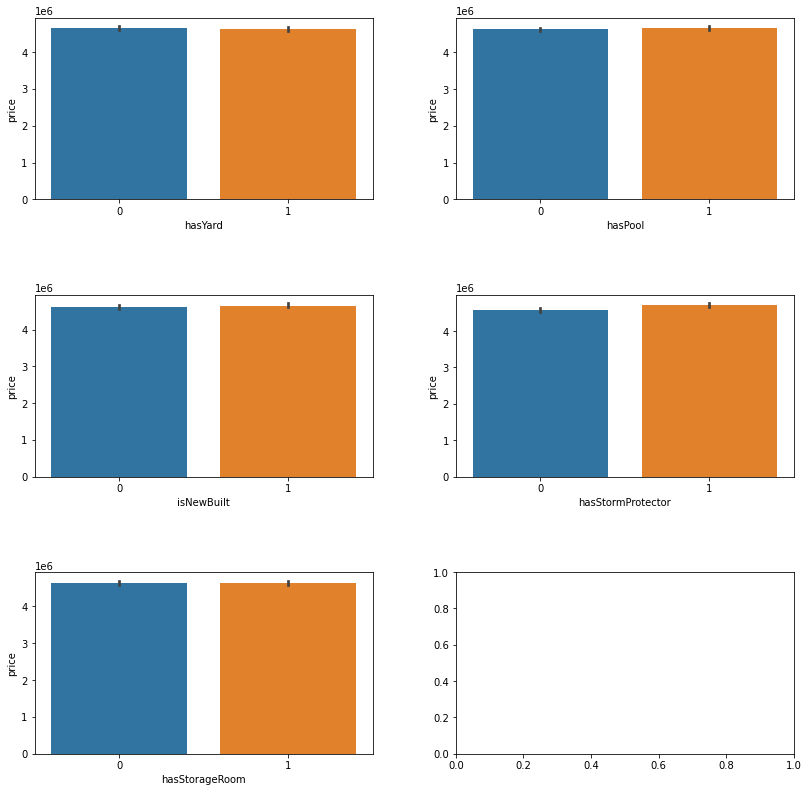

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.tight_layout() 
fig.set_size_inches(12,12)

# 바차트
sns.barplot(x='hasYard',y='price',data=train, ax=axes[0,0])
sns.barplot(x='hasPool',y='price',data=train, ax=axes[0,1])
sns.barplot(x='isNewBuilt',y='price',data=train, ax=axes[1,0])
sns.barplot(x='hasStormProtector',y='price',data=train, ax=axes[1,1])
sns.barplot(x='hasStorageRoom',y='price',data=train, ax=axes[2,0])

## 이상치 제거

In [ ]:
# drop those rows
train = train[train.made <= 2023]
train.reset_index(drop=True, inplace=True)

In [ ]:
# again drop, as we do not have such a high observation in test set
train = train[train.floors <= 100]
train.reset_index(drop=True, inplace=True)

# EDA 결과
- 피처제거
  - basement, attic, garage은 모두 음의 상관관계 - 미사용
  - train과 test간에 컬럼 불일치
  - temp, atemp 둘중 하나를 제거하는 조합, 둘다 사용해보는 조합(결과론)
  - windspeed 제거

## 수치형 데이터간 상관관계 체크
- 히트맵
- 강한 상관관계가 있다면 VIF 문제 발생(다중공선성 문제 발생), 신뢰성 저하 => 중요한 피처 1개만 사용

In [ ]:
corr_values = train[['numberOfRooms', 'floors', 'cityPartRange', 'numPrevOwners']].corr()
corr_values

,numberOfRooms,floors,cityPartRange,numPrevOwners
numberOfRooms,1.000000,0.077772,0.012284,0.021986
floors,0.077772,1.000000,0.007218,0.018508
cityPartRange,0.012284,0.007218,1.000000,0.021580
numPrevOwners,0.021986,0.018508,0.021580,1.000000


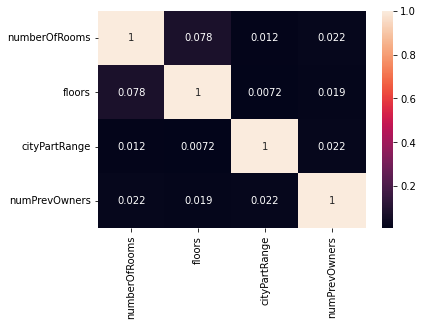

In [ ]:
sns.heatmap(corr_values, annot=True);
# 모든 피쳐는 약한 양의 상관관계를 가짐 -> 냅둠

# 베이스라인 구축 및 모델
- 데이터를 새로 올려서 깨끗하게 진행

## 피처 엔지니어링

In [ ]:
# 데이터 경로
path = '/content/drive/MyDrive/모듈프젝2/A팀-회귀/data/playground-series-season-3-episode-6/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

### 피처스케일링 및 데이터 합치기
- 훈련용과 테스트용 데이터를 병합해서 피처 엔지니어링 처리후 다시 분리 처리

In [ ]:
train.head(1)

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2


In [ ]:
test.head(1)

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
0,22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8


In [ ]:
train_test = pd.concat([train, test], ignore_index=True)
train_test.shape

(37884, 18)

### 피처 제거(선택)

- STEP 1. EDA를 통해서 제거 대상 선택
- STEP 2. 다중회귀
  - **후진 제거법**
    - 뒤에 있는 컬럼부터 제거하면서 학습->예측->평가 반복
  - **전진 선택법**
    - 앞에 있는 컬럼부터 선택하면서 학습->예측->평가 반복
  - 이런 조합을 통해 가장 좋은 결과가 나온 피처를 선택
  - **피처의 순서**도 영향을 미친다
- STEP 3. 학습중
  - L1 규제를 통해서 회귀계수를 0으로 만들어 피처를 제거(학습단계에 처리)


In [ ]:
# 'atemp'는 성능여하에 따라 추가할수도 있다(성능 올리기 위해서)
feats_drop = ['basement', 'attic', 'garage']
train_test = train_test.drop(feats_drop, axis=1)
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37884 entries, 0 to 37883
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 37884 non-null  int64  
 1   squareMeters       37884 non-null  int64  
 2   numberOfRooms      37884 non-null  int64  
 3   hasYard            37884 non-null  int64  
 4   hasPool            37884 non-null  int64  
 5   floors             37884 non-null  int64  
 6   cityCode           37884 non-null  int64  
 7   cityPartRange      37884 non-null  int64  
 8   numPrevOwners      37884 non-null  int64  
 9   made               37884 non-null  int64  
 10  isNewBuilt         37884 non-null  int64  
 11  hasStormProtector  37884 non-null  int64  
 12  hasStorageRoom     37884 non-null  int64  
 13  hasGuestRoom       37884 non-null  int64  
 14  price              22730 non-null  float64
dtypes: float64(1), int64(14)
memory usage: 4.3 MB


In [ ]:
train_test.shape

(37884, 15)

### 데이터 나누기
- 훈련 데이터 개수를 알고 있으므로, 슬라이싱 처리 가능
- 정답 데이터의 결측 여부로 분리해도 된다

In [ ]:
# 정답의 결측여부로 해결
X_sub = train_test[pd.isnull(train_test['price'])] # submission용
# 훈련용 
X = train_test[~pd.isnull(train_test['price'])] 
X.shape, X_sub.shape

((22730, 15), (15154, 15))

In [ ]:
X.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,0,7,6181908.8


In [ ]:
X_sub.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,hasStorageRoom,hasGuestRoom,price
22730,22730,47580,89,0,1,8,54830,5,3,1995,0,0,0,8,NaN
22731,22731,62083,38,0,0,87,8576,10,3,1994,1,1,1,4,NaN
22732,22732,90499,75,1,1,37,62454,9,6,1997,0,1,0,2,NaN
22733,22733,16354,47,1,1,9,9262,6,5,2019,1,1,1,5,NaN
22734,22734,67510,8,0,0,55,24112,3,7,2014,1,1,1,9,NaN


In [ ]:
X.head()
# 정답을 제거해서 y로 추출 별도 체크

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,0,7,6181908.8


In [ ]:
X

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,0,7,6181908.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22725,22725,55825,84,1,0,70,12031,3,10,2000,0,0,0,0,5594137.1
22726,22726,65870,88,1,0,49,23197,9,9,2015,0,1,0,7,6594705.0
22727,22727,93192,42,1,0,39,8539,10,5,2014,1,0,0,0,9321511.4
22728,22728,65797,86,1,0,89,23197,2,10,2000,1,0,0,0,6584708.2


# 실험

In [ ]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = X['price']
X_features = X.drop('price',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 2023866.685
Ridge 로그 변환된 RMSE: 2023866.802
Lasso 로그 변환된 RMSE: 2023866.727


[2023866.6853160814, 2023866.8018779866, 2023866.7268120968]

In [ ]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

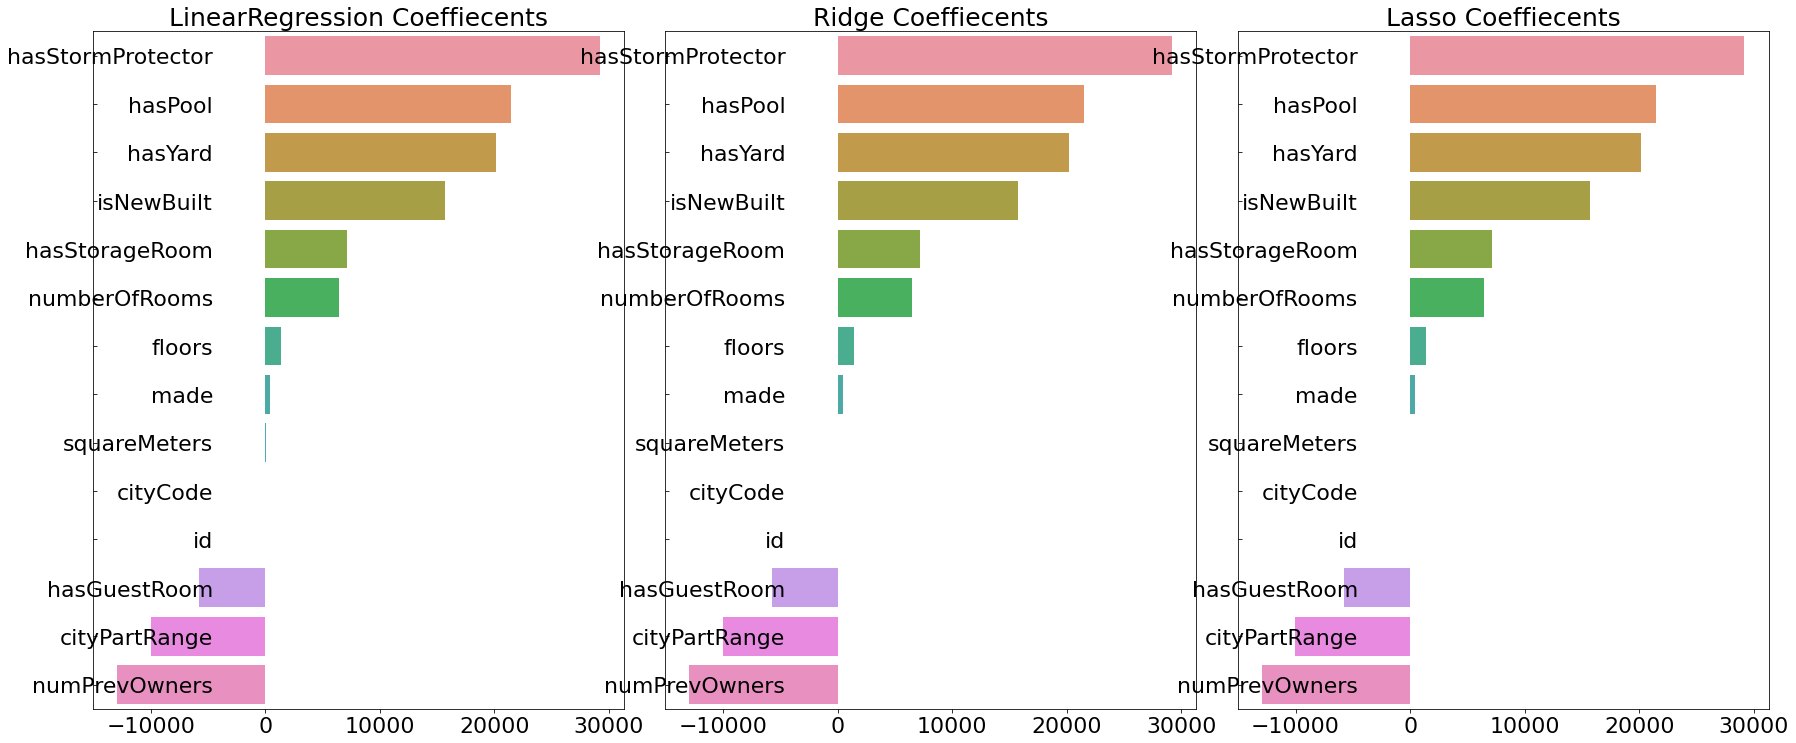

In [ ]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [2040376.218 2095395.586 2033968.245 8895941.106 2050388.565]
LinearRegression CV 평균 RMSE 값: 3423213.944

Ridge CV RMSE 값 리스트: [2040376.023 2095395.349 2033968.023 8895941.116 2050388.306]
Ridge CV 평균 RMSE 값: 3423213.763

Lasso CV RMSE 값 리스트: [2040376.106 2095395.416 2033968.121 8895941.335 2050388.369]
Lasso CV 평균 RMSE 값: 3423213.869


In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 4382525.1858, 최적 alpha:{'alpha': 20}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e+14, tolerance: 1.554e+13



Lasso 5 CV 시 최적 평균 RMSE 값: 4382526.806, 최적 alpha:{'alpha': 0.001}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.722e+14, tolerance: 1.945e+13



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e+14, tolerance: 1.562e+13



LinearRegression 로그 변환된 RMSE: 2023866.685
Ridge 로그 변환된 RMSE: 2023869.009
Lasso 로그 변환된 RMSE: 2023866.685


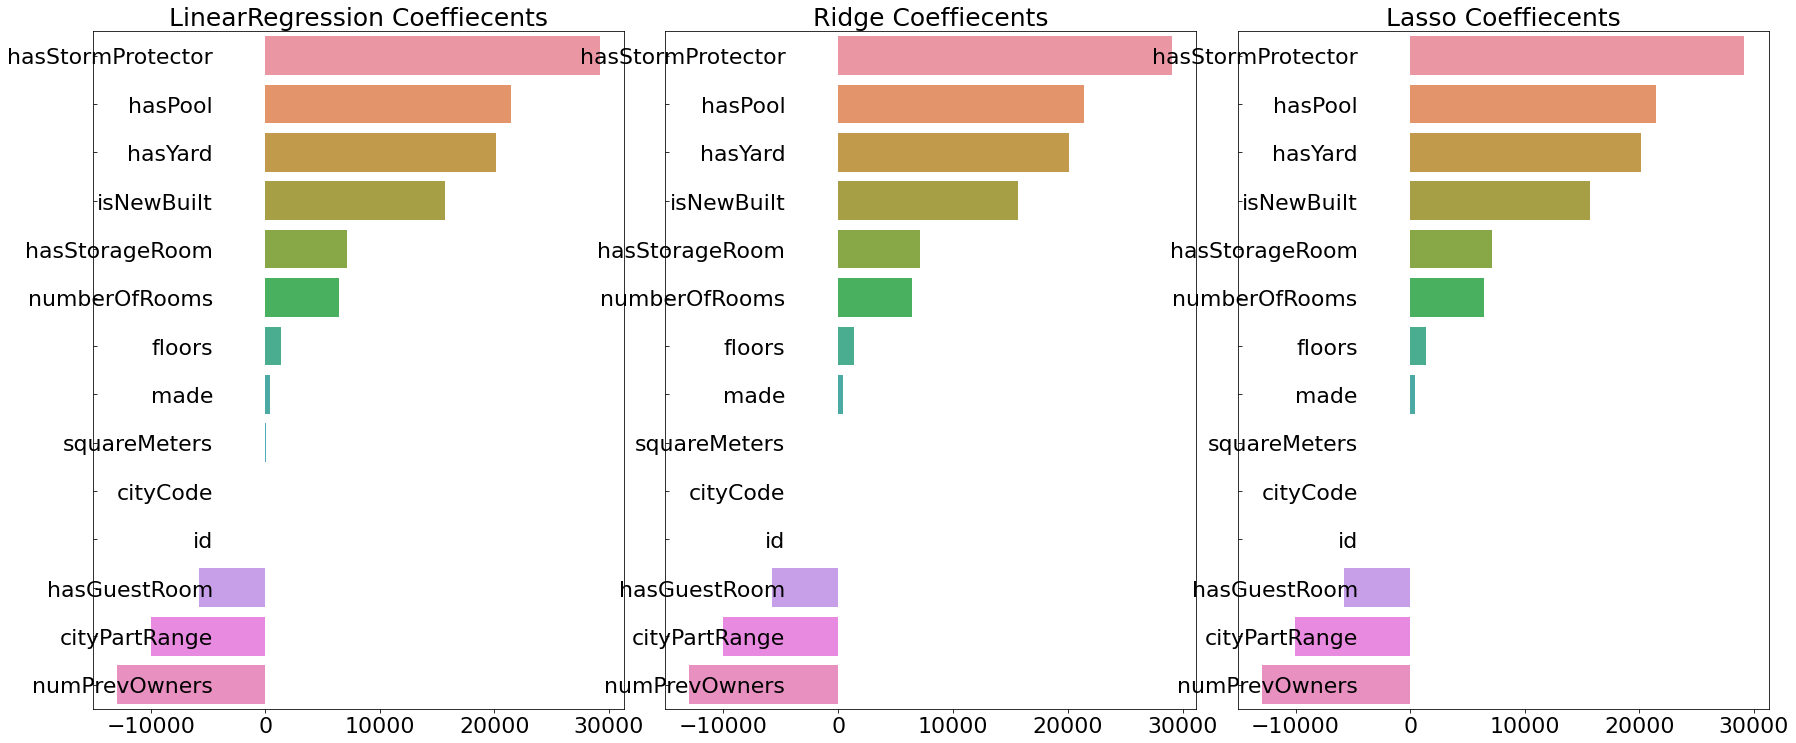

In [ ]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:

from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(objective='reg:squarederror',n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params) 

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 233177.8222, 최적 alpha:{'n_estimators': 1000}


In [ ]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 210064.3795, 최적 alpha:{'n_estimators': 1000}


In [ ]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 2023867.057788763
Ridge 모델의 RMSE: 2023867.616662983
Lasso 모델의 RMSE: 2023866.6853575392


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e+14, tolerance: 1.562e+13



In [ ]:
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 118327.1965155216
XGBM 모델의 RMSE: 106115.9734525604
LGBM 모델의 RMSE: 142279.31396977665


In [ ]:
from mlxtend.regressor import StackingCVRegressor

In [ ]:
X_train.head(1)

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,hasStorageRoom,hasGuestRoom
11817,11817,54096,79,0,1,33,82008,7,1,2009,1,1,0,8


In [ ]:
# 6개 모델 위에 xgboost 모델을 하나 더올려 stacking
stack = StackingCVRegressor(regressors=(xgb_reg, lgbm_reg, lasso_reg, ridge_reg),#svr
                                meta_regressor=xgb_reg,
                                use_features_in_secondary=True,
                                )

In [ ]:
stack_model = stack.fit(    X_train.values, y_train.values)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e+14, tolerance: 1.255e+13

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e+14, tolerance: 1.562e+13



In [ ]:
X_sub.columns

Index(['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'hasStorageRoom', 'hasGuestRoom', 'price'],
      dtype='object')

In [ ]:

X_sub = X_sub.drop(['price'], axis=1)
X_sub.values

In [ ]:
# 제출
sub_y_pred = stack_model.predict(X_sub.values)
submission['price'] = sub_y_pred
submission.to_csv( 'submission.csv', index=False )